In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.engine import Engine
from pathlib import Path
import yaml
import datetime

In [2]:
# Настроим подключение к базе данных
CONFIG_PATH = "config.yaml"
with open(CONFIG_PATH, "r", encoding="utf-8") as config_file:
    CONFIG = yaml.load(config_file, Loader=yaml.FullLoader)

CON = create_engine(
    CONFIG['database_url']
)

def select(query: str, con: Engine = CON) -> pd.DataFrame:
    """
    Функция обобщённого sql-запроса к базе данных соцсети, содержащей три таблицы:
    1. Данные пользователей user
    2. Данные постов post
    3. Данные действий пользователей в соцсети feed
    """
    return pd.read_sql(query, con)

##### Загрузим данные из базы

In [3]:
# Загрузим таблицу юзеров 
q = """
SELECT *
FROM public.user
"""

user_data = select(q)
user_data.head()

,id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [4]:
# Теперь таблицу постов 
q = """
SELECT *
FROM public.post
"""

post_data = select(q)
post_data.head()

,id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [5]:
# И таблицу взаимодействий

q1 = """
SELECT * 
FROM public.feed_data 
WHERE target = 1 AND EXTRACT(MONTH FROM timestamp) > 10
ORDER BY RANDOM()
LIMIT 3000000
"""

q2 = """
SELECT * 
FROM public.feed_data 
WHERE target = 0 AND EXTRACT(MONTH FROM timestamp) > 10
ORDER BY RANDOM()
LIMIT 3000000
"""

feed_likes_data = select(q1)
feed_views_data = select(q2)
feed_data = pd.concat([feed_likes_data, feed_views_data])

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-12-02 16:33:08,125319,302,view,1
1,2021-11-20 20:48:08,82334,1074,view,1
2,2021-11-13 06:21:26,37753,1673,view,1
3,2021-12-10 19:00:06,32560,950,view,1
4,2021-11-25 08:23:08,102644,959,view,1


In [6]:
# Высчитаем старт теста

ab_duration = datetime.timedelta(days=13)
ab_start_date = (feed_data.timestamp.max() - ab_duration).date()

print(f'Начало A\B-теста: {ab_start_date}')

Начало A\B-теста: 2021-12-16


In [7]:
# Разделим feed_data на трейн и тест

test_data = feed_data[feed_data.timestamp.dt.date >= ab_start_date]
feed_data = feed_data[feed_data.timestamp.dt.date < ab_start_date]

In [8]:
feed_data.shape, test_data.shape

((4555190, 5), (1444810, 5))

##### Получим итоговый датасет для решения задачи

In [9]:
# Смёрджим датафреймы для получения итогового датасета
user_data = user_data.rename(columns={'id': 'user_id'})
post_data = post_data.rename(columns={'id': 'post_id'})

train_data = feed_data.merge(
    user_data, on='user_id'
).merge(
    post_data, on='post_id'
)

train_data.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-12-02 16:33:08,125319,302,view,1,0,22,Russia,Volgograd,1,Android,organic,Ukraine steel sell-off illegal\n\nThe controve...,business
1,2021-11-09 12:43:49,37753,302,view,0,1,27,Ukraine,Lozova,2,Android,ads,Ukraine steel sell-off illegal\n\nThe controve...,business
2,2021-11-29 16:23:52,58932,302,like,0,0,35,Russia,Moscow,1,Android,ads,Ukraine steel sell-off illegal\n\nThe controve...,business
3,2021-11-10 07:17:43,138043,302,view,0,1,22,Russia,Pskov,0,iOS,organic,Ukraine steel sell-off illegal\n\nThe controve...,business
4,2021-11-28 06:27:53,3635,302,view,1,1,24,Russia,Ulyanovsk,2,Android,ads,Ukraine steel sell-off illegal\n\nThe controve...,business


In [10]:
train_data.shape

(4555190, 14)

In [11]:
# Сохраним датасеты для их дальнейшей обработки перед обучением модели

post_data.to_csv(CONFIG['data_folder'] + '/post_data.csv', index=False)
user_data.to_csv(CONFIG['data_folder'] + '/user_data.csv', index=False)
test_data.to_csv(CONFIG['data_folder'] + '/test_data.csv', index=False)
train_data.to_csv(CONFIG['datasets_folder'] + '/train_data.csv', index=False)

### Тестовые данные

В ходе решения было обнаружено, что нам нужно изменить тестовый датасет:
1. Распределение просмотров\лайков нужно более приближенное к реальности
2. Необходимо радикально уменьшить размер датафрейма, тк получение рекомендаций для 1.5кк записей занимает слишком много времени

In [13]:
# Загрузим 250 тысяч записей

q = """
SELECT * 
FROM public.feed_data 
WHERE EXTRACT(MONTH FROM timestamp) = 12 AND EXTRACT(DAY FROM timestamp) > 15
ORDER BY RANDOM()
LIMIT 250000
"""

test_data = select(q)
test_data.head()

,timestamp,user_id,post_id,action,target
0,2021-12-23 11:15:02,74168,3762,view,0
1,2021-12-24 17:30:11,161011,1427,view,1
2,2021-12-26 17:24:23,154745,5026,view,0
3,2021-12-27 21:20:12,117989,3752,view,0
4,2021-12-20 13:14:13,160820,5199,view,0


<AxesSubplot:>

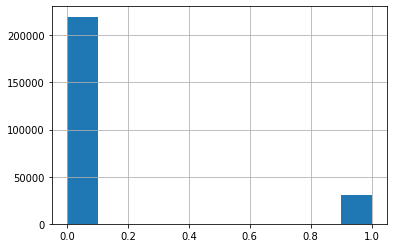

In [14]:
test_data.target.hist()

<AxesSubplot:>

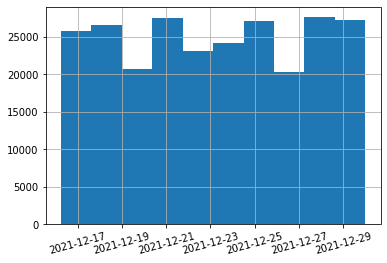

In [16]:
test_data.timestamp.hist(xrot=15)

In [19]:
test_data.to_csv(CONFIG['data_folder'] + '/test_data.csv', index=False)